In [166]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import copy
warnings.simplefilter("ignore")
plt.style.use("bmh")

In [167]:
df = pd.read_csv("data/atlantic.csv")

In [168]:
df["Time"] = df["Time"].astype("object")
time_replace = [str(x) for x in df["Time"].unique()]
for i, txt in enumerate(time_replace):
    time_replace[i] = txt.rjust(4, "0")
    time_replace[i] = f"{time_replace[i][0:2]}:{time_replace[i][2:4]}:00"
for old, new in zip(df["Time"].unique(), time_replace):
    df.loc[df["Time"]==old, "Time"] = new

In [169]:
df["Date"] = df["Date"].astype("object")
for i, date_str in enumerate(df["Date"].unique()):
    df.loc[df["Date"]==date_str, "Date"] = f"{str(date_str)[0:4]}-{str(date_str)[4:6]}-{str(date_str)[6:]}"

In [170]:
df["Datetime"] = df["Date"]+" "+df["Time"]
df["Datetime"] = pd.to_datetime(df["Datetime"])
df.drop(columns=["Date", "Time"], inplace=True)
df.sort_values(by=["Datetime"], inplace=True)

In [171]:
df["Name"] = df["Name"].str.strip()
df["Status"] = df["Status"].str.strip()
df["Event"] = df["Event"].str.strip()

In [172]:
print(f"Dataset contains data of {df['ID'].unique().shape[0]} individual storms from {df['Datetime'].dt.year.min()} to {df['Datetime'].dt.year.max()}.")

Dataset contains data of 1814 individual storms from 1851 to 2015.


In [173]:
def coordinate_mapping(x):
    coord = float(x[:-1])
    if x[-1]=="W":
        coord *= -1
    if x[-1]=="S":
        coord *= -1
    return coord

In [174]:
df["Latitude"] = df["Latitude"].apply(coordinate_mapping)
df["Longitude"] = df["Longitude"].apply(coordinate_mapping)

In [175]:
print("Min. Long.:", df.Longitude.min(), "Max. Long.:", df.Longitude.max(), "Min. Lat.:", df.Latitude.min(), "Max. Lat.:", df.Latitude.max())

Min. Long.: -359.1 Max. Long.: 63.0 Min. Lat.: 7.2 Max. Lat.: 81.0


In [176]:
df.loc[df.Longitude<-180, "Longitude"] = df.Longitude+360

In [177]:
gdf = gpd.GeoDataFrame(df,geometry=gpd.points_from_xy(df.Longitude,df.Latitude), crs={'init' :'epsg:3786'})

In [178]:
gdf.crs

<Derived Projected CRS: EPSG:3786>
Name: World Equidistant Cylindrical (Sphere)
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Coordinate Operation:
- name: World Equidistant Cylindrical (Sphere)
- method: Equidistant Cylindrical (Spherical)
Datum: Not specified (based on GRS 1980 Authalic Sphere)
- Ellipsoid: GRS 1980 Authalic Sphere
- Prime Meridian: Greenwich

In [179]:
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

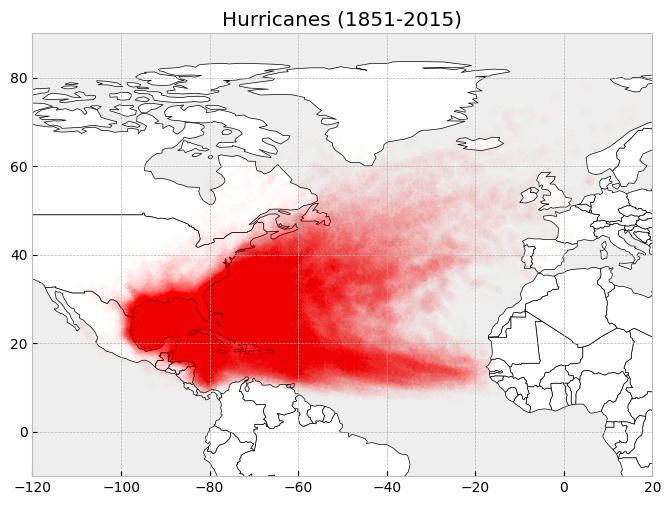

In [180]:
ax = world.plot(color="white", edgecolor="black", figsize=(8,8))
_ = gdf.plot(ax=ax, c="r", markersize="Maximum Wind", alpha=0.01)
_ = plt.xlim(-120, 20)
_ = plt.ylim(-10, 90)
_ = plt.title(f'Hurricanes (1851-2015)')

In [181]:
lat_min = gdf.Latitude.min()
long_min = gdf.Longitude.min()
gdf["x"] = gdf.Latitude-lat_min
gdf["x"] = gdf["x"]/gdf["x"].max()
gdf["y"] = gdf.Longitude-long_min
gdf["y"] = gdf["y"]/gdf["y"].max()

In [182]:
gdf["relative_time"] = ((gdf.Datetime.dt.dayofyear+(gdf.Datetime.dt.hour/24.)+(gdf.Datetime.dt.minute/60.*24))/366.) 
# Each day is 1/366 of a year (WITH 31th of december), each hour is a 1/24 of a day and each minute 1/60 of a hour.

In [183]:
gdf["month"] = gdf.Datetime.dt.month
gdf["hour"] = gdf.Datetime.dt.hour

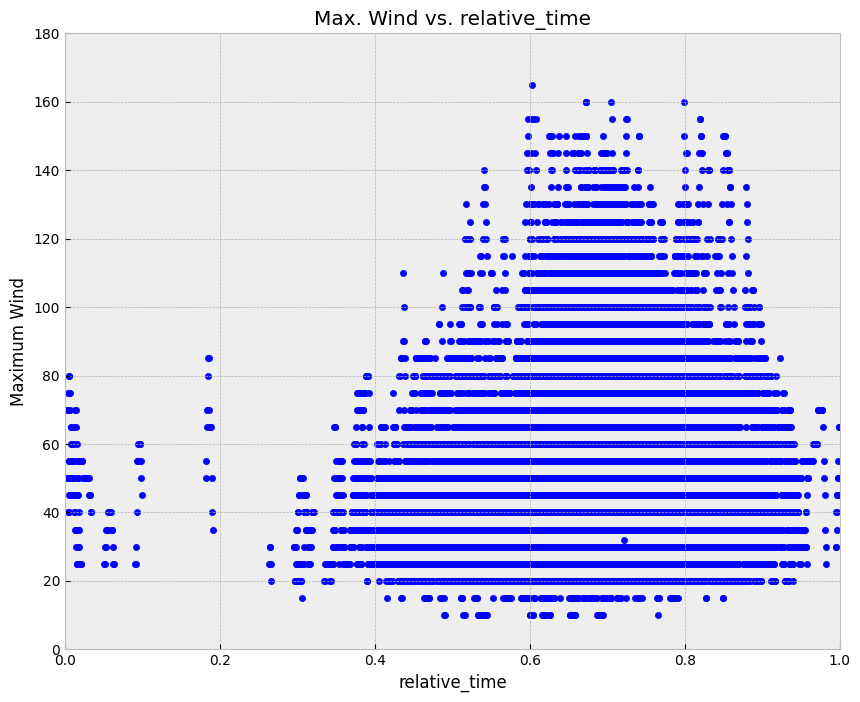

In [184]:
_ = gdf.plot(x="relative_time", y="Maximum Wind", kind="scatter", figsize=(10,8), title="Max. Wind vs. relative_time")
_ = plt.ylim(0,180)
_ = plt.xlim(0,1)

In [185]:
gdf["vec_x"] = np.nan
gdf["vec_y"] = np.nan
vecs = {"x": [], "y": [], "id": []}
for storm_id in gdf["ID"].unique():
    last_x = 0
    last_y = 0
    for i, row in gdf[gdf["ID"]==storm_id].iterrows():
        if last_x==0:
            last_x = row.x
            last_y = row.y
        else:
            vec_x = row.x-last_x
            vec_y = row.y-last_y
            vecs["x"].append(vec_x)
            vecs["y"].append(vec_y)
            vecs["id"].append(i)
            last_x = row.x
            last_y = row.y
gdf.loc[vecs["id"], "vec_x"] = vecs["x"]
gdf.loc[vecs["id"], "vec_y"] = vecs["y"]

In [186]:
gdf["vec_len"] = np.sqrt((gdf["vec_x"]**2)+(gdf["vec_y"]**2))

In [187]:
def calculate_direction(vec_x, vec_y):
    def vec_angle(a, b):
        return np.arccos(np.dot(a,b)/(np.linalg.norm(a)*np.linalg.norm(b)))
    ref_vec = np.array([vec_x, vec_y])
    N_vec = np.array([0,1])
    S_vec = np.array([0,-1])
    E_vec = np.array([1,0])
    W_vec = np.array([-1,0])
    N_angle = vec_angle(ref_vec, N_vec)
    E_angle = vec_angle(ref_vec, E_vec)
    W_angle = vec_angle(ref_vec, W_vec)
    return_angle = N_angle
    if W_angle<E_angle:
        return_angle = 2*np.pi-return_angle
    return return_angle

In [188]:
gdf["vec_direction"] = gdf.apply(lambda x: calculate_direction(x.vec_x, x.vec_y), axis=1)

In [189]:
gdf["tdelta"] = np.nan
tdeltas = {"t": [], "id": []}
for storm_id in gdf["ID"].unique():
    last_time = 0
    for i, row in gdf[gdf["ID"]==storm_id].iterrows():
        if last_time==0:
            last_time = row.Datetime
        else:
            tdeltas["t"].append((row.Datetime-last_time).seconds)
            tdeltas["id"].append(i)
            last_time = row.Datetime
gdf.loc[tdeltas["id"], "tdelta"] = tdeltas["t"]

In [190]:
print(gdf.shape)
gdf = gdf[gdf["tdelta"] % 21600 == 0]
print(gdf.shape)

(49105, 32)
(45717, 32)


In [191]:
#gdf["prev_len"] = np.nan
#gdf["prev_direction"] = np.nan
#prevs = {"len": [], "direction": [], "id": []}
#for storm_id in gdf["ID"].unique():
#    last_len = False
#    last_direction = False
#    for i, row in gdf[gdf["ID"]==storm_id].iterrows():
#        if last_len==False:
#            last_len = row.vec_len
#            last_direction = row.vec_direction
#        else:
#            prevs["len"].append(last_len)
#            prevs["direction"].append(last_direction)
#            prevs["id"].append(i)
#            last_len = row.vec_len
#            last_direction = row.vec_direction
#gdf.loc[prevs["id"], "prev_len"] = prevs["len"]
#gdf.loc[prevs["id"], "prev_direction"] = prevs["direction"]

In [192]:
def window_input_output(input_length: int, output_length: int, column: str, data: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    df = data.copy()
    i = 1
    while i < input_length:
        df[f'x{column[4:]}_{i}'] = df[column].shift(-i)
        i = i + 1    
    j = 0
    while j < output_length:
        df[f'y{column[4:]}_{j}'] = df[column].shift(-output_length-j)
        j = j + 1   
    df = df.dropna(axis=0)
    return df

In [193]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import RegressorChain
from sklearn.metrics import mean_squared_error

In [197]:
best_models = {'i':[], 'j':[], 'direction_model':[], 'direction_error':[], 'len_model':[], 'len_error':[]}

for i in range(4):
    for j in range(4):
        print(f"Predicting with {i+1} Input{'s'[:(i+1)^1]} on {j+1} Output{'s'[:(j+1)^1]}")
        seq_gdf = window_input_output(i+1, j+1, "vec_len", gdf)
        seq_gdf = window_input_output(i+1, j+1, "vec_direction", seq_gdf)
        
        X_direction_cols = ["Maximum Wind", "x", "y", "month", "hour",
              "vec_len","vec_direction"]
        X_direction_cols.extend([col for col in seq_gdf.columns if col.startswith('xd')])
        y_direction_cols = [col for col in seq_gdf.columns if col.startswith('yd')]

        X_direction_train = seq_gdf[X_direction_cols][:-1*round(seq_gdf.shape[1]*0.20)].values
        y_direction_train = seq_gdf[y_direction_cols][:-1*round(seq_gdf.shape[1]*0.20)].values
        X_direction_test = seq_gdf[X_direction_cols][-1*round(seq_gdf.shape[1]*0.20):].values
        y_direction_test = seq_gdf[y_direction_cols][-1*round(seq_gdf.shape[1]*0.20):].values


        X_len_cols = ["Maximum Wind", "x", "y", "month", "hour",
                    "vec_len","vec_direction"]
        X_len_cols.extend([col for col in seq_gdf.columns if col.startswith('xl')])
        y_len_cols = [col for col in seq_gdf.columns if col.startswith('yl')]

        X_len_train = seq_gdf[X_len_cols][:-1*round(seq_gdf.shape[1]*0.20)].values
        y_len_train = seq_gdf[y_len_cols][:-1*round(seq_gdf.shape[1]*0.20)].values
        X_len_test = seq_gdf[X_len_cols][-1*round(seq_gdf.shape[1]*0.20):].values
        y_len_test = seq_gdf[y_len_cols][-1*round(seq_gdf.shape[1]*0.20):].values

        print("\tDirection Models")

        dt_direction_seq = DecisionTreeRegressor(random_state=42)
        dt_direction_seq.fit(X_direction_train, y_direction_train)
        dt_direction_seq_preds = dt_direction_seq.predict(X_direction_test)
        print(f"\t\tDecision Tree Direction MSE: {mean_squared_error(y_direction_test, dt_direction_seq_preds)}")

        gbr_direction_seq = GradientBoostingRegressor(random_state=42)
        chained_direction_gbr = RegressorChain(gbr_direction_seq)
        chained_direction_gbr.fit(X_direction_train, y_direction_train)
        gbr_direction_seq_preds = chained_direction_gbr.predict(X_direction_test)
        print(f"\t\tGBR Direction MSE: {mean_squared_error(y_direction_test, gbr_direction_seq_preds)}")

        print("\tLength Models")

        dt_len_seq = DecisionTreeRegressor(random_state=42)
        dt_len_seq.fit(X_len_train, y_len_train)
        dt_len_seq_preds = dt_len_seq.predict(X_len_test)
        print(f"\t\tDecision Tree Length MSE: {mean_squared_error(y_len_test, dt_len_seq_preds)}")

        gbr_len_seq = GradientBoostingRegressor(random_state=42)
        chained_len_gbr = RegressorChain(gbr_len_seq)
        chained_len_gbr.fit(X_len_train, y_len_train)
        gbr_len_seq_preds = chained_len_gbr.predict(X_len_test)
        print(f"\t\tGBR Length MSE: {mean_squared_error(y_len_test, gbr_len_seq_preds)}")



Predicting with 1 Input on 1 Output
	Direction Models
		Decision Tree Direction MSE: 2.6044417750654496
		GBR Direction MSE: 2.4803275016172486
	Length Models
		Decision Tree Length MSE: 0.0001643389634064557
		GBR Length MSE: 1.8988965274269768e-05
Predicting with 1 Input on 2 Outputs
	Direction Models
		Decision Tree Direction MSE: 2.2369429573378743
		GBR Direction MSE: 0.2987209171602062
	Length Models
		Decision Tree Length MSE: 0.00017320491565595963
		GBR Length MSE: 7.532985457214182e-05
Predicting with 1 Input on 3 Outputs
	Direction Models
		Decision Tree Direction MSE: 1.3723854320780002
		GBR Direction MSE: 0.5605155183579518
	Length Models
		Decision Tree Length MSE: 0.00030578314884560144
		GBR Length MSE: 0.00015963914874326477
Predicting with 1 Input on 4 Outputs
	Direction Models
		Decision Tree Direction MSE: 3.0222788989688416
		GBR Direction MSE: 0.7371702443653698
	Length Models
		Decision Tree Length MSE: 0.00030624219018429716
		GBR Length MSE: 0.0001996810432845